In [1]:
!nvidia-smi

Wed Feb 15 09:00:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [ ]:
import sys
sys.path.append('..')

In [2]:
import os
os.environ['TOKENIZERS_PARALLELISM']='true'
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [3]:
import re
import os
import torch
import json
import numpy as np
import pandas as pd
import seaborn as sns
import transformers
import catalyst
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from typing import Callable, Union, Tuple
from catalyst.loggers.wandb import WandbLogger
from tqdm.notebook import tqdm
from collections import Counter
from torch import nn
from catalyst import dl
from catalyst.callbacks.periodic_loader import PeriodicLoaderCallback
from langdetect import detect
from easse.sari import corpus_sari
from rouge import Rouge 

from utils.dataset_utils import extract_com8text_from_tgt, extract_text8docs_from_src
from utils.dataset_utils import EditDataset, get_tgt, get_src, COM_SEP, TEXT_SEP_SRC, TEXT_SEP_TGT, DOCS_SEP
from utils.metrics_utils import PeerEditMetricsCallback
from utils.config import Config


DOCS_DIR = 'data'
PAGES_DIR = 'data'

In [4]:
CONFIG = Config()
CONFIG.seed = 1337

In [5]:
import random

random.seed(CONFIG.seed)
os.environ['PYTHONHASHSEED'] = str(CONFIG.seed)
np.random.seed(CONFIG.seed)
torch.manual_seed(CONFIG.seed)
torch.cuda.manual_seed(CONFIG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Data preparing

In [6]:
mp = json.load(open(r"data/column_mapper.json"))

train = pd.read_json(r'data/new_train.json')
train.set_axis(mp.values(), axis='columns', inplace=True)

test = pd.read_json(r'data/new_test.json')
test.set_axis(mp.values(), axis='columns', inplace=True)

val = pd.read_json(r'data/new_val.json')
val.set_axis(mp.values(), axis='columns', inplace=True)
val1 = val.sample(600)

In [7]:
train.head()

,obj_id,old_text,new_text,comment,docs,diff,title,search_queries,counter_found_docs,section_name,is_good,docs_processed
0,1005,"In rural regions of Germany, especially the Ha...","In rural regions of Germany, especially the Ha...",/* Germany */ grammar,"Apr 30, 2020 — Depending on whom you ask, May ...","this opportunity to party,",May Day,"[May Day Germany this opportunity to party,]",[27],Germany,True,"DOC0: Apr 30, 2020 — Depending on whom you ask..."
1,55,"""This is the new WikiPedia!"" \n-HomePage, the ...","""This is the new WikiPedia!"" \n-HomePage, the ...",Added subpage,English: Results of the 1929 New York City ald...,\n*/New York City Board of Aldermen,John M Wolfson,[John M Wolfson \n*/New York City Board of Ald...,"[10, 4]",,True,DOC0: English: Results of the 1929 New York Ci...
2,2329,"Ares (Ancient Greek: , Μodern Greek: Άρης ) i...","Ares (Ancient Greek: , Μodern Greek: Άρης ) i...",repaired link to 'masculinity' ~~~~,"Apr 7, 2014 — Let's explore the essence of mas...","masculinity, integrity, and personal courage.",Ares,"[Ares masculinity, integrity, and personal cou...",[30],,True,"DOC0: Apr 7, 2014 — Let's explore the essence ..."
3,17206,Peter Velhorn (born 24 November 1932) is a Ger...,Peter Velhorn (24 November 1932 – 20 July 2016...,"Passed away 2016, look at German article",Peter Velhorn (24 November 1932 – 20 July 2016...,– 20 July 2016,Peter Velhorn,[Peter Velhorn – 20 July 2016],[23],,True,DOC0: Peter Velhorn (24 November 1932 – 20 Jul...
4,47,"Michael Palin was educated at Birkdale School,...","Michael Palin was educated at Birkdale School,...",/* Early career */ added info,"Michael Palin, Nightingale House, in Clapham, ...",", Graeme Garden, Bill Oddie and Jonathan Lynn",Michael Palin,"[Michael Palin Early career , Graeme Garden, ...",[29],Early career,True,"DOC0: Michael Palin, Nightingale House, in Cla..."


In [ ]:
train.iloc[0]['']

In [8]:
CONFIG.src_max_len = 1024
CONFIG.tgt_max_len = 512
CONFIG.pretrained = 't5-small'
CONFIG.batch_size = 4

tokenizer = T5Tokenizer.from_pretrained(CONFIG.pretrained, model_max_length=CONFIG.src_max_len)

In [9]:
idx = 1
el_idx = train.iloc[idx]

docs = el_idx['docs_processed']
comment = el_idx['comment']
old_text = el_idx['old_text']
new_text = el_idx['new_text']

print(f'Old text: {old_text}\n\n')
print(f'New text: {new_text}\n\n')
print(f'Comment: {comment}\n\n')
print(f'Docs: {docs}\n\n')

src = get_src(el_idx)
tgt = get_tgt(el_idx)

print(f'Src: {src}\n\n')
print(f'Tgt: {tgt}\n\n')

comment, new_text = extract_com8text_from_tgt(tgt)
old_text, docs = extract_text8docs_from_src(src)

print(f'Extracted Old text: {old_text}\n\n')
print(f'Extracted New text: {new_text}\n\n')
print(f'Extracted Comment: {comment}\n\n')
print(f'Extracted Docs: {docs}\n\n')

Old text: "This is the new WikiPedia!" 
-HomePage, the first ever article created on Wikipedia, created by office.bomis.com on Mon, 15 Jan 2001 19:27:13 



Interested in Chicago and urban history, and other things. 

SUBPAGES (Excl. Sandbox):
*/Chicago aldermanic notability
*/Louis B. Anderson
*/Chicago City Council since 1923
*/Town of Chicago

"FORMER" SUBPAGES (content moved elsewhere, now serving as redirects):
*/Notabilitymandering
*/List of Chicago aldermen since 1923
*/Chicago aldermanic elections before 1923


New text: "This is the new WikiPedia!" 
-HomePage, the first ever article created on Wikipedia, created by office.bomis.com on Mon, 15 Jan 2001 19:27:13 



Interested in Chicago and urban history, and other things. 

SUBPAGES (Excl. Sandbox):
*/Chicago aldermanic notability
*/Louis B. Anderson
*/Chicago City Council since 1923
*/Town of Chicago
*/New York City Board of Aldermen

"FORMER" SUBPAGES (content moved elsewhere, now serving as redirects):
*/Notabilitymandering

**Make dataset**

In [10]:
ds_train = EditDataset(train, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)
ds_val = EditDataset(val1, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)
ds_val_full = EditDataset(val, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)

**Len distribution**

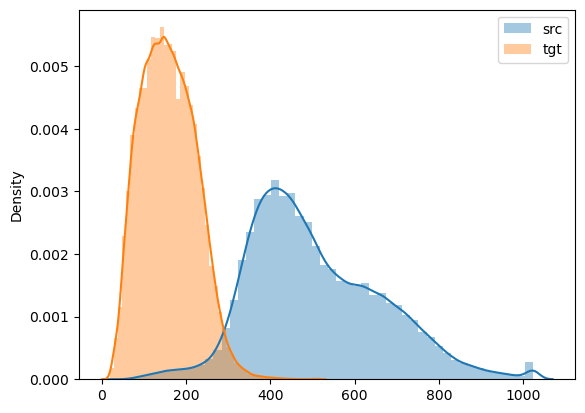

In [11]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in ds_train:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.distplot(arr_src, label='src');
plt.legend();
sns.distplot(arr_tgt, label='tgt');
plt.legend();

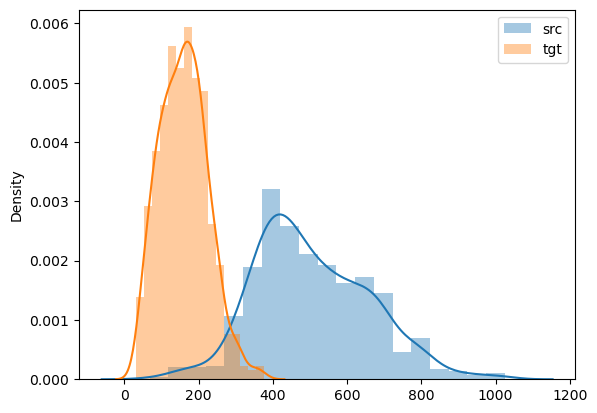

In [12]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in ds_val:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.distplot(arr_src, label='src');
plt.legend();
sns.distplot(arr_tgt, label='tgt');
plt.legend();

In [13]:
idx_num = 100
src_text = tokenizer.decode(ds_train[idx_num][0]['input_ids'], skip_special_tokens=True)
tgt_text = tokenizer.decode(ds_train[idx_num][1]['input_ids'], skip_special_tokens=True)

In [14]:
print(f'{src_text}\n\n{tgt_text}')

TEXT_SEP artheneidae is a family of true bugs in the order hemiptera. there are about 7 genera and at least 20 described species in artheneidae. DOCS_SEP doc0: artheneidae is a family of true bugs in the order hemiptera. it was formerly included in lygaeidae. there are about 7 genera and at least 20 described doc1: the family was vastly larger, but numerous former subfamilies have been removed and given independent family status, including the artheneidae, blissidae, doc2: artheneidae is a family of true bugs in the order hemiptera. it was formerly included in lygaeidae.[1] there are about 7 genera and at least 20 described doc3: may 31, 2009 — formerly treated under lygaeidae. numbers. "key to species of artheneidae of north america (from hoffman 1996)(3): doc4: items 1 - 20 of 15671 — the lygaeidae are a family in the hemiptera (true bugs),. the family was vastly larger, but numerous former subfamilies have been doc5: the family used to be vastly larger, as numerous former subfamilie

## Model training

In [15]:
loaders = {
    'train': torch.utils.data.DataLoader(ds_train, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True),
    'valid_full': torch.utils.data.DataLoader(ds_val_full, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=False),
    'valid_subset': torch.utils.data.DataLoader(ds_val, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=False)
}

In [16]:
class EditModel(nn.Module):
    def __init__(self, 
                 pretrained: transformers.modeling_utils.PreTrainedModel, 
                 config: Config):
        super(EditModel, self).__init__()
        self.pretrained = pretrained
        

    def forward(self, 
                x: Tuple[torch.Tensor, torch.Tensor]):
        src, tgt = x
        
        tgt[tgt == 0] == -100
        
        loss = self.pretrained(
            input_ids = src,
            attention_mask = (src != 0).float(),
            labels=tgt,
        ).loss
        return loss
    
    
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        
    def forward(self, pred, tgt):
        return pred

In [17]:
model = EditModel(
    T5ForConditionalGeneration.from_pretrained(CONFIG.pretrained),
    CONFIG
)
CONFIG.optimizer = 'Adam(lr=0.0001)'
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

CONFIG.name = f'{CONFIG.pretrained} stage 2'
CONFIG.description = f'{CONFIG.name} p(comment, x_t+1 | x_t, doc)'
CONFIG.group = "wiki_edit"

In [18]:
!rm -rf ./models/"{CONFIG.description}"

In [ ]:
from catalyst.core import IRunner
from catalyst.metrics._additive import AdditiveMetric
from catalyst.callbacks.metric import BatchMetricCallback, ICallbackBatchMetric


class AccMetric(ICallbackBatchMetric):
    def __init__(self, topk, compute_on_call=False):
        super().__init__(compute_on_call=compute_on_call, prefix='', suffix='')
        self.metric_name = 'sql_acc'
        self.topk = topk
        self.metrics: List[AdditiveMetric] = [
            AdditiveMetric(compute_on_call=compute_on_call) for _ in range(len(self.topk))]

    def reset(self) -> None:
        for metric in self.metrics:
            metric.reset()

    def update(self, values, n_samples):
        for value, metric in zip(values, self.metrics):
            metric.update(value, n_samples)
        return values

    def update_key_value(self, values, n_samples):
        values = self.update(values, n_samples)
        output = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, values)
        }
        return output

    def compute(self):
        means, stds = zip(*(metric.compute() for metric in self.metrics))
        return means, stds

    def compute_key_value(self):
        means, stds = self.compute()
        output_mean = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, means)
        }
        output_std = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}/std": round(value, 6)
            for key, value in zip(self.topk, stds)
        }
        return {**output_mean, **output_std}


class AccCallback(BatchMetricCallback):

    def __init__(self, beam_size):
        super().__init__(
            metric=AccMetric((1,beam_size)) if beam_size > 1 else AccMetric((1,)),
            input_key='features', target_key='targets', log_on_batch=True)
        self.beam_size = beam_size

    def on_batch_end(self, runner: "IRunner") -> None:

        if runner.loader_key == 'train':
            runner.model.train()
        elif runner.loader_key.startswith('valid'):
            runner.model.eval()

            src = runner.batch['features'][0]
            tgt = runner.batch['features'][1]
            max_len = tgt.shape[1]
            with torch.no_grad():
                pred = runner.model.pretrained.generate(src.to(runner.engine.device),
                                                        attention_mask=(src != 0).float().to(runner.engine.device),
                                                        # pad_token_id=tokenizer.pad_token_id,
                                                        # bos_token_id=tokenizer.bos_token_id,
                                                        # eos_token_id=tokenizer.eos_token_id,
                                                        num_beams=self.beam_size,
                                                        num_return_sequences=self.beam_size,
                                                        max_length=max_len
                                                        )

            pred = pred[:,1:]
            pred = pred.view(-1, self.beam_size, pred.shape[1])
            acck = 0
            acc1 = 0
            for i in range(tgt.shape[0]):
                tgt_subseq = tgt[i, :pred.shape[2]].to(runner.engine.device)

                acck += float(torch.any(torch.all(tgt_subseq == pred[i], dim=1)))
                acc1 += float(torch.all(tgt_subseq == pred[i, 0]))

            acck /= len(src)
            acc1 /= len(src)

            metrics = self.metric.update_key_value([acc1, acck], len(src))

            runner.batch_metrics.update(metrics)

    def on_loader_end(self, runner: "IRunner") -> None:
        if runner.loader_key.startswith('valid'):
            metrics = self.metric.compute_key_value()
            metrics = runner.engine.mean_reduce_ddp_metrics(metrics)
            runner.loader_metrics.update(metrics)

In [19]:
CONFIG.n_epochs = 35

In [20]:
METRIC_LIST = [
    'full__exact_match@1',
    'text__exact_match@1',
    'text__diff_exact_match@1',
    'comment__exact_match@1',
    'text__sari@1',
    'text__rouge-1@1',
    'text__rouge-2@1',
    'text__rouge-l@1'
]   

In [ ]:
runner = dl.SupervisedRunner()

wandb_logger = WandbLogger(project="interactive_lm", 
                              name=CONFIG.name, 
                              group=CONFIG.group)

runner.train(
    loaders=loaders,
    model=model,
    criterion=Criterion(),
    optimizer=optimizer,
    num_epochs=CONFIG.n_epochs,
    callbacks=[
        PeriodicLoaderCallback(
            valid_loader_key='valid_full',
            valid_metric_key='loss',
            minimize=True,
            **{'valid_full': 5}
        ),
        PeerEditMetricsCallback(METRIC_LIST, tokenizer),
        dl.optimizer.OptimizerCallback(metric_key='loss', accumulation_steps=4),
    ],
    loggers={'wandb': wandb_logger},
    logdir=f'./models/{CONFIG.description}',
    valid_loader='valid_subset',
    valid_metric='loss',
    minimize_valid_metric=True,
    verbose=True,
#     check=True,
#     cpu=True,
)

wandb: Currently logged in as: anton-sh. Use `wandb login --relogin` to force relogin


1/35 * Epoch (train):   0%|          | 0/29890 [00:00<?, ?it/s]

train (1/35) loss: 0.43199090642369004 | loss/mean: 0.43199090642369004 | loss/std: 0.2329313013465438 | lr: 0.0001 | momentum: 0.9


1/35 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (1/35) comment__exact_match@1: 0.0 | comment__exact_match@1/std: 0.0 | full__exact_match@1: 0.0 | full__exact_match@1/std: 0.0 | loss: 0.3522328029076258 | loss/mean: 0.3522328029076258 | loss/std: 0.14610656577337988 | lr: 0.0001 | momentum: 0.9 | text__diff_exact_match@1: 0.021389 | text__diff_exact_match@1/std: 0.063287 | text__exact_match@1: 0.015 | text__exact_match@1/std: 0.059421 | text__rouge-1@1: 0.902002 | text__rouge-1@1/std: 0.082355 | text__rouge-2@1: 0.870195 | text__rouge-2@1/std: 0.086718 | text__rouge-l@1: 0.900318 | text__rouge-l@1/std: 0.082815 | text__sari@1: 33.119327 | text__sari@1/std: 5.320233
* Epoch (1/35) 


2/35 * Epoch (train):   0%|          | 0/29890 [00:00<?, ?it/s]

train (2/35) loss: 0.3625630353564652 | loss/mean: 0.3625630353564652 | loss/std: 0.14073348439279 | lr: 0.0001 | momentum: 0.9


2/35 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (2/35) comment__exact_match@1: 0.001667 | comment__exact_match@1/std: 0.020361 | full__exact_match@1: 0.001667 | full__exact_match@1/std: 0.020361 | loss: 0.33567184989651033 | loss/mean: 0.33567184989651033 | loss/std: 0.14321856762128193 | lr: 0.0001 | momentum: 0.9 | text__diff_exact_match@1: 0.038492 | text__diff_exact_match@1/std: 0.095408 | text__exact_match@1: 0.031667 | text__exact_match@1/std: 0.092709 | text__rouge-1@1: 0.914001 | text__rouge-1@1/std: 0.059697 | text__rouge-2@1: 0.880041 | text__rouge-2@1/std: 0.06962 | text__rouge-l@1: 0.91168 | text__rouge-l@1/std: 0.060256 | text__sari@1: 35.694366 | text__sari@1/std: 7.422838
* Epoch (2/35) 


3/35 * Epoch (train):   0%|          | 0/29890 [00:00<?, ?it/s]

train (3/35) loss: 0.3452450775756678 | loss/mean: 0.3452450775756678 | loss/std: 0.13655063486957517 | lr: 0.0001 | momentum: 0.9


3/35 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (3/35) comment__exact_match@1: 0.001667 | comment__exact_match@1/std: 0.020361 | full__exact_match@1: 0.001667 | full__exact_match@1/std: 0.020361 | loss: 0.3260809808472792 | loss/mean: 0.3260809808472792 | loss/std: 0.14026433618169712 | lr: 0.0001 | momentum: 0.9 | text__diff_exact_match@1: 0.049028 | text__diff_exact_match@1/std: 0.106022 | text__exact_match@1: 0.043333 | text__exact_match@1/std: 0.10315 | text__rouge-1@1: 0.917708 | text__rouge-1@1/std: 0.052671 | text__rouge-2@1: 0.88284 | text__rouge-2@1/std: 0.063856 | text__rouge-l@1: 0.914621 | text__rouge-l@1/std: 0.053456 | text__sari@1: 36.292482 | text__sari@1/std: 7.606898
* Epoch (3/35) 


4/35 * Epoch (train):   0%|          | 0/29890 [00:00<?, ?it/s]

train (4/35) loss: 0.3339269377034467 | loss/mean: 0.3339269377034467 | loss/std: 0.13406917637033325 | lr: 0.0001 | momentum: 0.9


4/35 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (4/35) comment__exact_match@1: 0.001667 | comment__exact_match@1/std: 0.020361 | full__exact_match@1: 0.001667 | full__exact_match@1/std: 0.020361 | loss: 0.32143303508559856 | loss/mean: 0.32143303508559856 | loss/std: 0.13989475864422854 | lr: 0.0001 | momentum: 0.9 | text__diff_exact_match@1: 0.063479 | text__diff_exact_match@1/std: 0.121127 | text__exact_match@1: 0.043333 | text__exact_match@1/std: 0.10712 | text__rouge-1@1: 0.909296 | text__rouge-1@1/std: 0.056629 | text__rouge-2@1: 0.869188 | text__rouge-2@1/std: 0.070302 | text__rouge-l@1: 0.905266 | text__rouge-l@1/std: 0.057492 | text__sari@1: 37.910384 | text__sari@1/std: 8.017624
* Epoch (4/35) 


5/35 * Epoch (train):   0%|          | 0/29890 [00:00<?, ?it/s]

train (5/35) loss: 0.3251114904324651 | loss/mean: 0.3251114904324651 | loss/std: 0.13077943937901898 | lr: 0.0001 | momentum: 0.9


5/35 * Epoch (valid_full):   0%|          | 0/1661 [00:00<?, ?it/s]

valid_full (5/35) comment__exact_match@1: 0.007978 | comment__exact_match@1/std: 0.043946 | full__exact_match@1: 0.005871 | full__exact_match@1/std: 0.037861 | loss: 0.3075938685418681 | loss/mean: 0.3075938685418681 | loss/std: 0.12645534531730582 | lr: 0.0001 | momentum: 0.9 | text__diff_exact_match@1: 0.076037 | text__diff_exact_match@1/std: 0.11658 | text__exact_match@1: 0.054042 | text__exact_match@1/std: 0.112691 | text__rouge-1@1: 0.908351 | text__rouge-1@1/std: 0.055586 | text__rouge-2@1: 0.86927 | text__rouge-2@1/std: 0.067641 | text__rouge-l@1: 0.905021 | text__rouge-l@1/std: 0.056564 | text__sari@1: 39.797188 | text__sari@1/std: 7.90698


5/35 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (5/35) comment__exact_match@1: 0.003333 | comment__exact_match@1/std: 0.028698 | full__exact_match@1: 0.001667 | full__exact_match@1/std: 0.020361 | loss: 0.3165225010613602 | loss/mean: 0.3165225010613602 | loss/std: 0.1385487793998872 | lr: 0.0001 | momentum: 0.9 | text__diff_exact_match@1: 0.065139 | text__diff_exact_match@1/std: 0.119422 | text__exact_match@1: 0.04 | text__exact_match@1/std: 0.100416 | text__rouge-1@1: 0.905135 | text__rouge-1@1/std: 0.057995 | text__rouge-2@1: 0.864696 | text__rouge-2@1/std: 0.070353 | text__rouge-l@1: 0.90042 | text__rouge-l@1/std: 0.058779 | text__sari@1: 38.310704 | text__sari@1/std: 7.991295
* Epoch (5/35) 


6/35 * Epoch (train):   0%|          | 0/29890 [00:00<?, ?it/s]

train (6/35) loss: 0.31839229335560437 | loss/mean: 0.31839229335560437 | loss/std: 0.12989899165315302 | lr: 0.0001 | momentum: 0.9


6/35 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (6/35) comment__exact_match@1: 0.003333 | comment__exact_match@1/std: 0.028698 | full__exact_match@1: 0.001667 | full__exact_match@1/std: 0.020361 | loss: 0.3128262328604857 | loss/mean: 0.3128262328604857 | loss/std: 0.13807307182061837 | lr: 0.0001 | momentum: 0.9 | text__diff_exact_match@1: 0.062139 | text__diff_exact_match@1/std: 0.115425 | text__exact_match@1: 0.033333 | text__exact_match@1/std: 0.089828 | text__rouge-1@1: 0.904583 | text__rouge-1@1/std: 0.057473 | text__rouge-2@1: 0.860471 | text__rouge-2@1/std: 0.07169 | text__rouge-l@1: 0.89989 | text__rouge-l@1/std: 0.058586 | text__sari@1: 38.600455 | text__sari@1/std: 8.410184
* Epoch (6/35) 


7/35 * Epoch (train):   0%|          | 0/29890 [00:00<?, ?it/s]

CONFIG.beam_size = 1

device = runner.engine.device
runner.model.eval()
with torch.no_grad():
    for i in [0, 1, 2]:
        src_, tgt_ = ds_train[i]
        src_inp = torch.tensor(src_['input_ids']).view(1,-1).to(runner.engine.device)
        generated = runner.model.pretrained.generate(src_inp,
                                              attention_mask=(src_inp != 0).float().to(runner.engine.device),
                                            # pad_token_id=tokenizer.pad_token_id,
                                            # bos_token_id=tokenizer.bos_token_id,
                                            # eos_token_id=tokenizer.eos_token_id,
                                              num_beams=CONFIG.beam_size,
                                              num_return_sequences=CONFIG.beam_size,
                                              max_length=1000
        )
        
        tgt_full = tokenizer.decode(tgt_['input_ids'], skip_special_tokens=True).strip()
        tgt_comment, tgt_text = extract_com8text_from_tgt(tgt_full)

        src_full = tokenizer.decode(src_['input_ids'], skip_special_tokens=True).strip()
        src_text, _ = extract_text8docs_from_src(src_full)
        
        
        print(f'\n\n----------------------------\t QUERY {i}\t ----------------------------\n')
        print(f'Src query:\n {src_text}')
        print(f'\nTgt query:\n {tgt_text}')
        print(f'\nTgt comment:\n {tgt_comment}')
        
        print(f'\n\n----------------------------\t GENERATED\t ----------------------------\n')

        pred_full = []
        pred_texts = []
        pred_comments = []
        for j in range(CONFIG.beam_size):
            to_gen = generated[j]
            gen_text = tokenizer.decode(to_gen, skip_special_tokens=True)
            com_prediction, text_prediction = extract_com8text_from_tgt(gen_text)
            
            pred_full.append(gen_text)
            pred_texts.append(text_prediction)
            pred_comments.append(com_prediction)
            
            print(f'{j} TEXT:\n{text_prediction}\n')
            print(f'{j} COMMENT:\n{com_prediction}\n\n')
        
        print('Text sari:', sari_one(src_text, tgt_text, pred_texts))
        print('Com em:', topN_diff_exact_match_one('', tgt_comment, pred_comments))
        print('Full em:', topN_diff_exact_match_one(src_full, tgt_full, pred_full))
        print('Text em:', topN_diff_exact_match_one(src_text, tgt_text, pred_texts))
        print('Rouge text:', rouge_one(src_text, tgt_text, pred_texts)['rouge-1'])